# 量子神经网络的贫瘠高原效应


<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## 概览

在经典神经网络的训练中，基于梯度的优化方法不仅仅会遇到局部最小值的问题，同时还要面对鞍点等附近梯度近似于零的几何结构。相对应的，在量子神经网络中也存在着一种**贫瘠高原效应**（barren plateaus）。这个奇特的现象首先是由 McClean et al. 在 2018 年发现 [[1]](https://arxiv.org/abs/1803.11173)。简单来说，就是当你选取的随机电路结构满足一定复杂程度时优化曲面（optimization landscape）会变得很平坦，从而导致基于梯度下降的优化方法很难找到全局最小值。对于大多数的变分量子算法（VQE等），这个现象意味着当量子比特数量越来越多时，选取随机结构的电路有可能效果并不好。这会让你设计的损失函数所对应的优化曲面变成一个巨大的高原，让从而导致量子神经网络的训练愈加困难。你随机找到的初始值很难逃离这个高原，梯度下降收敛速度会很缓慢。

![BP-fig-barren](./figures/BP-fig-barren-cn.png)

图片由 [Gradient Descent Viz](https://github.com/lilipads/gradient_descent_viz) 生成


基于梯度变化对这类变分量子算法训练的影响，我们在量桨（Paddle Quantum）平台提供了梯度分析工具模块，辅助用户对 QML 模型进行诊断，便于贫瘠高原等问题的研究。

本教程主要讨论如何在量桨（Paddle Quantum）平台上展示贫瘠高原现象，以及如何使用梯度分析工具对用户自定义量子神经网络中的参数梯度进行分析。其中并不涉及任何算法创新，但能提升读者对于量子神经网络训练中梯度问题的认识。

首先我们先引入必要的 library 和 package：


In [1]:
# 忽略 waring 输出
import warnings
warnings.filterwarnings("ignore")

# 需要用的包
import time
import numpy as np
from math import pi
import paddle
from paddle_quantum.ansatz import Circuit
from paddle_quantum.linalg import dagger
from paddle_quantum.loss import ExpecVal
from paddle_quantum.state import zero_state
# 画图工具
from matplotlib import pyplot as plt 


/Users/v_zhanglei48/opt/anaconda3/envs/pq/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
/Users/v_zhanglei48/opt/anaconda3/envs/pq/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


## 随机的网络结构

这里我们按照原作者 McClean (2018) [[1]](https://arxiv.org/abs/1803.11173) 论文中提及的类似方法搭建如下随机电路：

![BP-fig-Barren_circuit](./figures/BP-fig-Barren_circuit.png)

首先作用在所有量子比特上绕布洛赫球的 Y-轴旋转 $\pi/4$。

其余的结构加起来构成一个模块（Block）, 每个模块共分为两层：

- 第一层搭建随机的旋转门, 其中 $R_{\ell,n} \in \{R_x, R_y, R_z\}$。下标 $\ell$ 表示处于第 $\ell$ 个重复的模块， 上图中 $\ell =1$。第二个下标 $n$ 表示作用在第几个量子比特上。
- 第二层由 CZ 门组成，作用在每两个相邻的量子比特上。

在量桨中, 我们可以这么搭建。

In [2]:
def rand_circuit(target, num_qubits, theta=None):
    # 初始化量子电路
    cir = Circuit(num_qubits)
    
    # 固定角度的 Ry 旋转门
    cir.ry(param=pi / 4)

    # ============== 第一层 ==============
    # target是一个随机的数组,用来帮助我们抽取随机的单比特门 
    for i in range(num_qubits):
        if target[i] == 0:
            cir.rz(i, param=theta[i] if theta is not None else theta)
        elif target[i] == 1:
            cir.ry(i, param=theta[i] if theta is not None else theta)
        else:
            cir.rx(i, param=theta[i] if theta is not None else theta)
            
    # ============== 第二层 ==============
    # 搭建两两相邻的 CZ 门
    for i in range(num_qubits - 1):
        cir.cz([i, i + 1])
        
    return cir

## 损失函数与优化曲面 

当我们确定了电路的结构之后，我们还需要定义一个损失函数（loss function）来确定优化曲面。按照原作者 McClean (2018) [[1]](https://arxiv.org/abs/1803.11173) 论文中提及的，我们采用 VQE算法中常用的损失函数：

$$
\mathcal{L}(\boldsymbol{\theta})= \langle0| U^{\dagger}(\boldsymbol{\theta})H U(\boldsymbol{\theta}) |0\rangle,
\tag{1}
$$

其中的酉矩阵 $U(\boldsymbol{\theta})$ 就是我们上一部分搭建的带有随机结构的量子神经网络。对于其中的哈密顿量 $H$ 我们不妨先取最简单的形式 $H = |00\cdots 0\rangle\langle00\cdots 0|$。设定好这些后，我们就可以从最简单的两个量子比特的情形开始采样了 -- 生成300组随机网络结构和不同的随机初始参数 $\{\theta_{\ell,n}^{(i)}\}_{i=1}^{300}$。每次计算梯度都是按照 VQE 的解析梯度公式计算关于 **第一个参数 $\theta_{1,1}$** 的偏导数。然后统计得到的这300个梯度的平均值和方差。其中解析梯度的公式为：

$$
\partial \theta_{j} 
\equiv \frac{\partial \mathcal{L}}{\partial \theta_j}
= \frac{1}{2} \big[\mathcal{L}(\theta_j + \frac{\pi}{2}) - \mathcal{L}(\theta_j - \frac{\pi}{2})\big].
\tag{2}
$$

具体推导请参见：[arXiv:1803.00745](https://arxiv.org/abs/1803.00745)

In [3]:
# 超参数设置
# np.random.seed(42)        # 固定 Numpy 的随机种子
N = 2                     # 设置量子比特数量 
samples = 300             # 设定采样随机网络结构的数量
THETA_SIZE = N            # 设置参数 theta 的大小
ITR = 1                   # 设置迭代次数
LR = 0.2                  # 设定学习速率
SEED = 1                  # 固定优化器中随机初始化的种子

# 初始化梯度数值的寄存器
grad_info = []

# paddle.seed(SEED)

class manual_gradient(paddle.nn.Layer):
    
    # 初始化一个可学习参数列表，并用 [0, 2*pi] 的均匀分布来填充初始值
    def __init__(self, shape, param_attr=paddle.nn.initializer.Uniform(low=0.0, high=2*pi), dtype='float32'):
        super(manual_gradient, self).__init__()
        
        # 将 Numpy array 转换成 Paddle 中的 Tensor
        self.H = zero_state(N).data
        
    # 定义损失函数和前向传播机制    
    def forward(self):
        
        # 初始化三个 theta 参数列表
        theta_np = np.random.uniform(low=0., high=2*pi, size=(THETA_SIZE))
        theta_plus_np = np.copy(theta_np) 
        theta_minus_np = np.copy(theta_np) 
        
        # 修改用以计算解析梯度
        theta_plus_np[0] += pi/2
        theta_minus_np[0] -= pi/2
        
        # 将 Numpy array 转换成 Paddle 中的 Tensor
        theta_plus = paddle.to_tensor(theta_plus_np)
        theta_minus = paddle.to_tensor(theta_minus_np)
        
        # 生成随机目标，在 rand_circuit 中随机选取电路门
        target = np.random.choice(3, N)      
        
        U_plus = rand_circuit(target, N, theta_plus).unitary_matrix()
        U_minus = rand_circuit(target, N, theta_minus).unitary_matrix()

        # 计算解析梯度
        grad = paddle.real((dagger(U_plus) @ self.H @ U_plus)[0][0] - (dagger(U_minus) @ self.H @ U_minus)[0][0])/2  
        
        return grad

# 定义主程序段
def main():
    
    # 设置QNN的维度
    sampling = manual_gradient(shape=[THETA_SIZE])

    # 采样获得梯度信息
    grad = sampling().numpy()   
        
    return grad


# 记录运行时间
time_start = time.time()

# 开始采样
for i in range(samples):
    if __name__ == '__main__':
        grad = main()
        grad_info.append(grad)

time_span = time.time() - time_start        
print('主程序段总共运行了', time_span, '秒')
print("采样", samples, "个随机网络关于第一个参数梯度的均值是：", np.mean(grad_info))
print("采样", samples, "个随机网络关于第一个参数梯度的方差是：", np.var(grad_info))

/Users/v_zhanglei48/opt/anaconda3/envs/pq/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:


主程序段总共运行了 2.0201921463012695 秒
采样 300 个随机网络关于第一个参数梯度的均值是： -0.002514134
采样 300 个随机网络关于第一个参数梯度的方差是： 0.11258849


## 优化曲面的可视化

接下来我们试着利用 Matplotlib来可视化这个优化曲面（optimization landscape）。在**两个量子比特**的情况下，我们只有两个参数 $\theta_1$ 和 $\theta_2$, 并且第二层的随机电路电路总共有9种情况。这个很容易画出来：

![BP-fig-landscape2](./figures/BP-fig-landscape2.png)

可以看到的是最后一张图中 $R_z$-$R_z$ 结构所展示出的平原结构是我们非常不想见到的。在这种情况下，我们不能收敛到理论最小值。如果你想自己试着画一些优化曲面，不妨参见以下代码：

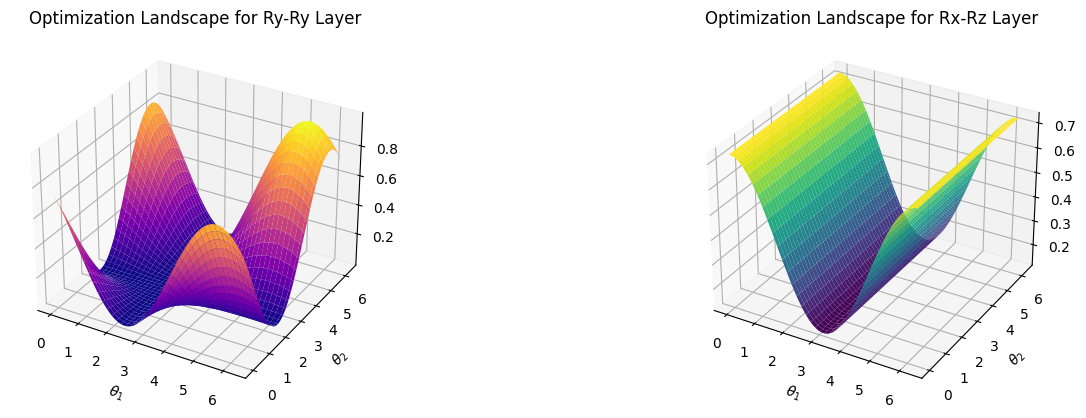

主程序段总共运行了 1.368649959564209 秒


In [4]:
time_start = time.time()
N = 2

# 设置图像比例 竖：横 = 0.3 
fig = plt.figure(figsize=plt.figaspect(0.3))

# 生成 x, y 轴上的点
X = np.linspace(0, 2 * pi, 80)
Y = np.linspace(0, 2 * pi, 80)

# 生成 2D 网格 (mesh)
xx, yy = np.meshgrid(X, Y)


# 定义必要的逻辑门
def rx(theta):
    mat = np.array([[np.cos(theta/2), -1j * np.sin(theta/2)],
                    [-1j * np.sin(theta/2), np.cos(theta/2)]])
    return mat

def ry(theta):
    mat = np.array([[np.cos(theta/2), -1 * np.sin(theta/2)],
                    [np.sin(theta/2), np.cos(theta/2)]])
    return mat

def rz(theta):
    mat = np.array([[np.exp(-1j * theta/2), 0],
                    [0, np.exp(1j * theta/2)]])
    return mat

def CZ():
    mat = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, -1]])
    return mat

# ============= 第一张图 =============
# 我们可视化第二层是 kron(Ry, Ry) 的情况
ax = fig.add_subplot(1, 2, 1, projection='3d')

# 向前传播计算损失函数：
def cost_yy(para):
    L1 = np.kron(ry(pi/4), ry(pi/4))
    L2 = np.kron(ry(para[0]), ry(para[1]))
    U = np.matmul(np.matmul(L1, L2), CZ())
    H = np.zeros((2 ** N, 2 ** N))
    H[0, 0] = 1
    val = (U.conj().T @ H @ U).real[0][0]
    return val

# 画出图像
Z = np.array([[cost_yy([x, y]) for x in X] for y in Y]).reshape(len(Y), len(X))
surf = ax.plot_surface(xx, yy, Z, cmap='plasma')
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")
ax.set_title("Optimization Landscape for Ry-Ry Layer")

# ============= 第二张图 =============
# 我们可视化第二层是 kron(Rx, Rz) 的情况
ax = fig.add_subplot(1, 2, 2, projection='3d')


def cost_xz(para):
    L1 = np.kron(ry(pi/4), ry(pi/4))
    L2 = np.kron(rx(para[0]), rz(para[1]))
    U = np.matmul(np.matmul(L1, L2), CZ())
    H = np.zeros((2 ** N, 2 ** N))
    H[0, 0] = 1
    val = (U.conj().T @ H @ U).real[0][0]
    return val

Z = np.array([[cost_xz([x, y]) for x in X] for y in Y]).reshape(len(Y), len(X))
surf = ax.plot_surface(xx, yy, Z, cmap='viridis')
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")
ax.set_title("Optimization Landscape for Rx-Rz Layer")


plt.show()

time_span = time.time() - time_start        
print('主程序段总共运行了', time_span, '秒')

## 梯度分析工具

基于梯度在贫瘠高原等现象中的表现出的重要作用，我们在量桨平台开发了一个简单的梯度分析工具，辅助用户查看电路中各参数的梯度情况，方便对量子神经网络做后续研究。

需要注意的是，我们使用梯度分析工具时仅需用户**单独定义传入的电路和损失函数，不需要用户自己写网络训练**，减少使用负担

### 应用 一：无监督学习

对于该类情况，主要关注类似变分量子本征求解器（VQE）的变分量子算法。该类变分算法要优化的目标函数通常是量子电路关于哈密顿量 $H$ 的期望值，即 $O(\theta) = \left\langle0\dots 0\right\lvert U^{\dagger}(\theta)HU(\theta) \left\lvert0\dots 0\right\rangle$，这里的 $U(\theta)$ 表示的就是参数化量子电路，其中 $\theta = [\theta_1, \theta_2, \dots, \theta_n]$ 是电路中的可训练参数，$H$ 是哈密顿量。 

这里我们就以 VQE 做代表，演示该梯度分析工具的用法。

#### Paddle Quantum 实现

首先导入该问题需要的包：

In [5]:
# 需要用的包
from paddle_quantum.qinfo import pauli_str_to_matrix, random_pauli_str_generator
from paddle_quantum.hamiltonian import Hamiltonian
# 导入梯度工具包
from paddle_quantum.gradtool import random_sample, show_gradient, plot_loss_grad, show_gradient

#### 定义量子电路

接着，构造目标函数 $O(\theta) = \left\langle00\right\lvert U^{\dagger}(\theta)HU(\theta) \left\lvert00\right\rangle$ 中的参数化量子电路 $U(\theta)$。这里我们还是采用上文中定义的随机电路。

#### 定义目标函数

之后给出要优化的目标函数（这里需要注意的是，在梯度分析模块中我们是以 ``loss_func(circuit, *args)`` 的形式调用函数计算目标函数值的。这也就是说，第二个参数是可变参数，用户可以根据需要灵活的构造自己模型的目标函数形式）：

In [6]:
# 要优化的目标函数，其中参数分别是电路和哈密顿量
def loss_func(circuit: Circuit, H: Hamiltonian) -> paddle.Tensor:
    expec_val = ExpecVal(H)
    return expec_val(circuit())

接着设置一些应用所需的参数

In [7]:
# 超参数设置
# np.random.seed(1)        # 固定 Numpy 的随机种子
N = 2                    # 设置量子比特数量 
samples = 300             # 设定采样随机网络结构的数量
THETA_SIZE = N            # 设置参数 theta 的大小  
ITR = 120                 # 设置迭代次数
LR = 0.1                  # 设定学习速率
SEED = 2                  # 固定优化器中随机初始化的种子

随机生成参数化量子电路，以及哈密顿量信息列表。

In [8]:
# paddle.seed(SEED)
target = np.random.choice(3, N)
# 在 0 - 2*Pi 间随机生成各参数值
cir = rand_circuit(target, N)
print(cir)
# 随机生成哈密顿量
H_l = Hamiltonian(random_pauli_str_generator(N, terms=7))
print('Hamiltonian info: \n', H_l)

--Ry(0.785)----Ry(5.090)----*--
                            |  
--Ry(0.785)----Rz(4.853)----z--
                               
Hamiltonian info: 
 -0.11659613736881846 X0
0.7564519922877542 Z0
-0.5665789011512152 Y0, Y1
0.47839020497319384 Z0, Y1
0.8831698245631991 X0, Z1
-0.37755591215283 Y0
0.5686545814476456 Z0, X1


``cir`` 和 ``H_l`` 就是要优化的目标函数 ``loss_func`` 所需的参数。

用户可以通过我们提供的梯度分析工具，查看电路中各参数梯度采样的结果。同时，可以根据需求在 ``single``, ``max``, 以及 ``random`` 三种模式间选择，其中 ``single`` 会返回电路多次采样后每个参数的平均值和方差， ``max`` 模式返回每轮采样中所有参数梯度最大值的均值和方差，``random`` 则是在每轮采样得到的各参数梯度中随机选择一个后计算均值和方差。

我们首先对该电路采样 300 次，这里我们选择 ``single`` 模式，看看电路中每个可变参数梯度的平均值和方差，同时默认 ``param=0`` 表示我们查看第一个参数的梯度分布情况。

Sampling: 100%|##################################################| 300/300 [00:02<00:00, 105.66it/s]


Mean of gradient for all parameters: 
theta 1 :  0.008229507
theta 2 :  -0.015562029
Variance of gradient for all parameters: 
theta 1 :  0.64334434
theta 2 :  0.18892294


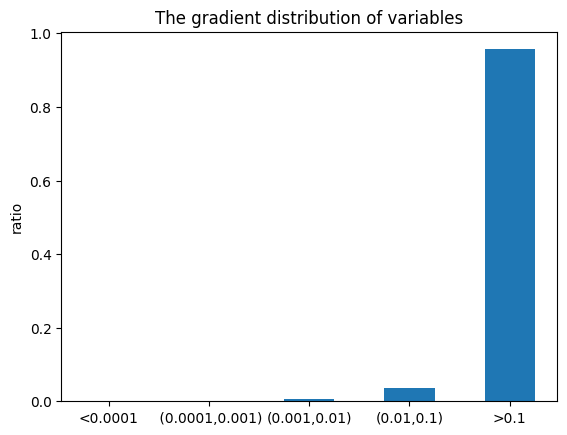

In [9]:
grad_mean_list, grad_variance_list = random_sample(cir, loss_func, samples, H_l, mode='single', param=0)

用户如果想要查看该量子电路在训练过程中梯度和损失值的变化情况，还可以使用 ``plot_loss_grad`` 函数，辅助查看电路的训练效果。

Training:   0%|                                                             | 0/120 [00:00<?, ?it/s]/Users/v_zhanglei48/opt/anaconda3/envs/pq/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
/Users/v_zhanglei48/opt/anaconda3/envs/pq/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprec

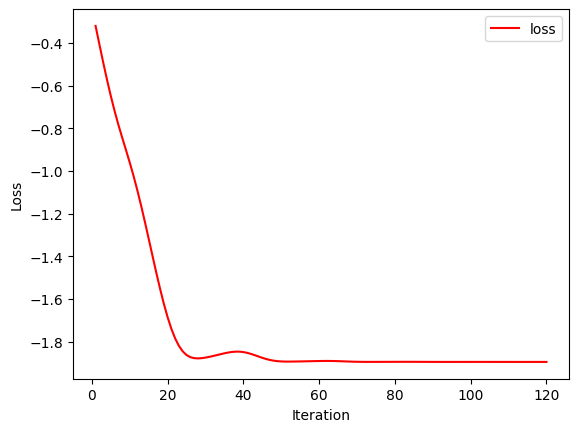

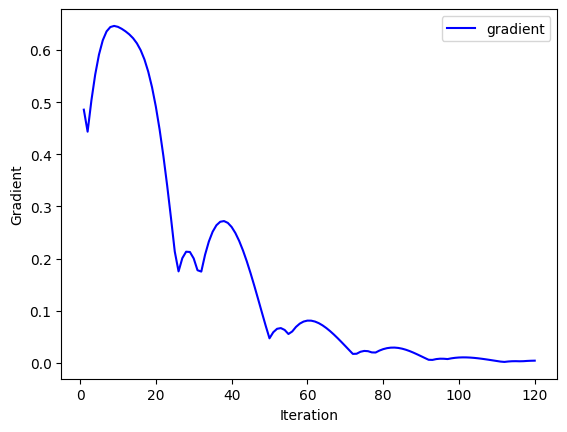

In [10]:
plot_loss_grad(cir, loss_func, ITR, LR, H_l)

如上图所示，可以看出 iteration 在几十次后损失函数的值就基本不发生变化了，而梯度也非常的接近 0。为了更直观的看到训练得到的最优解和理论值的差距，我们计算哈密顿量 ``H_l`` 的特征值。

In [11]:
loss, grad = show_gradient(cir, loss_func, ITR, LR, H_l)
H_matrix = H_l.construct_h_matrix()

print("最终的优化结果： ", loss[-1])
print("实际的基态能量：", np.linalg.eigh(H_matrix)[0][0])

Training: 100%|##################################################| 120/120 [00:01<00:00, 104.60it/s]


最终的优化结果：  -1.8954318
实际的基态能量： -2.3761654


通过对比可以看出，该电路训练得到的最优解和我们要得到的实际值之间还存在一定的差距。

#### 更多的量子比特

由于在贫瘠高原效应中，梯度会随着量子比特数的增加呈指数级消失。所以我们可以进一步对比增加电路中量子比特的数量，看看会对我们的梯度带来什么影响  (这里我们采样时选择 ``max`` 模式，对参数列表中的最大值做计算)。

Sampling: 100%|###################################################| 300/300 [00:03<00:00, 99.81it/s]


Mean of max gradient
0.93205416
Variance of max gradient
0.1852078


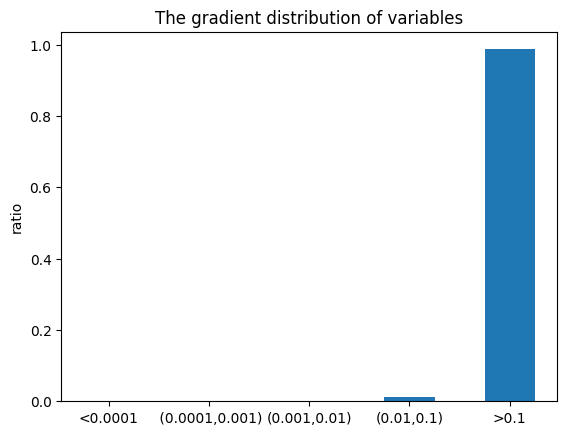

Sampling:   0%|                                                             | 0/300 [00:00<?, ?it/s]/Users/v_zhanglei48/opt/anaconda3/envs/pq/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
/Users/v_zhanglei48/opt/anaconda3/envs/pq/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprec

Mean of max gradient
0.37676528
Variance of max gradient
0.01785401


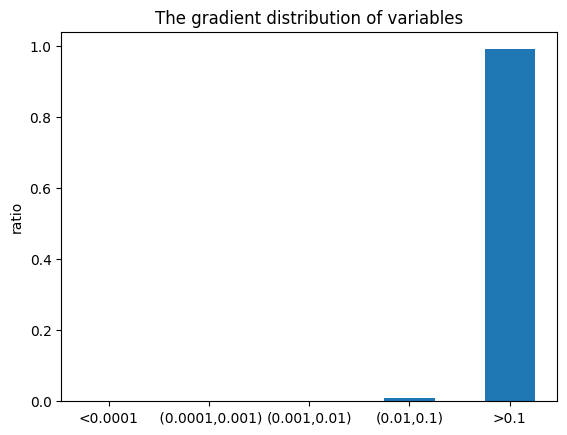

Sampling:   0%|                                                             | 0/300 [00:00<?, ?it/s]/Users/v_zhanglei48/opt/anaconda3/envs/pq/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
/Users/v_zhanglei48/opt/anaconda3/envs/pq/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprec

Mean of max gradient
0.27273464
Variance of max gradient
0.016345166


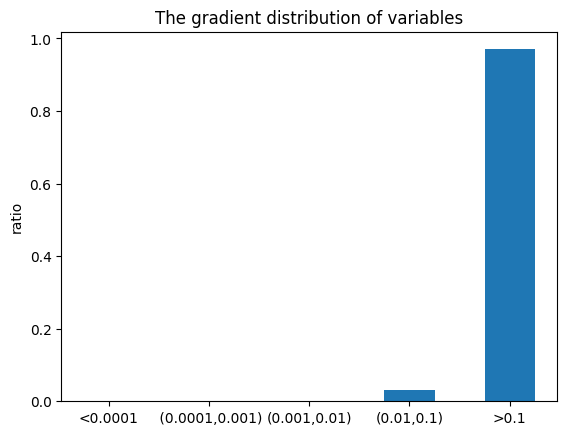

Sampling:   0%|                                                             | 0/300 [00:00<?, ?it/s]/Users/v_zhanglei48/opt/anaconda3/envs/pq/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
/Users/v_zhanglei48/opt/anaconda3/envs/pq/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprec

Mean of max gradient
0.14403
Variance of max gradient
0.004961067


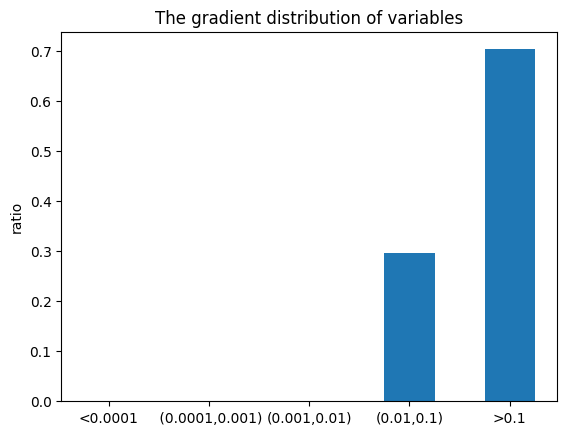

In [12]:
# 超参数设置
selected_qubit = [2, 4, 6, 8]
means, variances = [], []

# 不断增加量子比特数量
for N in selected_qubit:
    grad_info = []
    THETA_SIZE = N                
    target = np.random.choice(3, N)
    # 在 0 - 2*Pi 间随机生成各参数值
    cir = rand_circuit(target, N)
    
    H_l = Hamiltonian(random_pauli_str_generator(N, terms=10))
    
    grad_mean_list, grad_variance_list = random_sample(cir, loss_func, samples, H_l, mode='max')
    # 记录采样信息
    means.append(grad_mean_list)
    variances.append(grad_variance_list)


接着对采样不同量子比特数量电路得到的各参数最大梯度的平均值和方差作图，方便比较。

我们接着画出这个采样出来的梯度的统计结果：


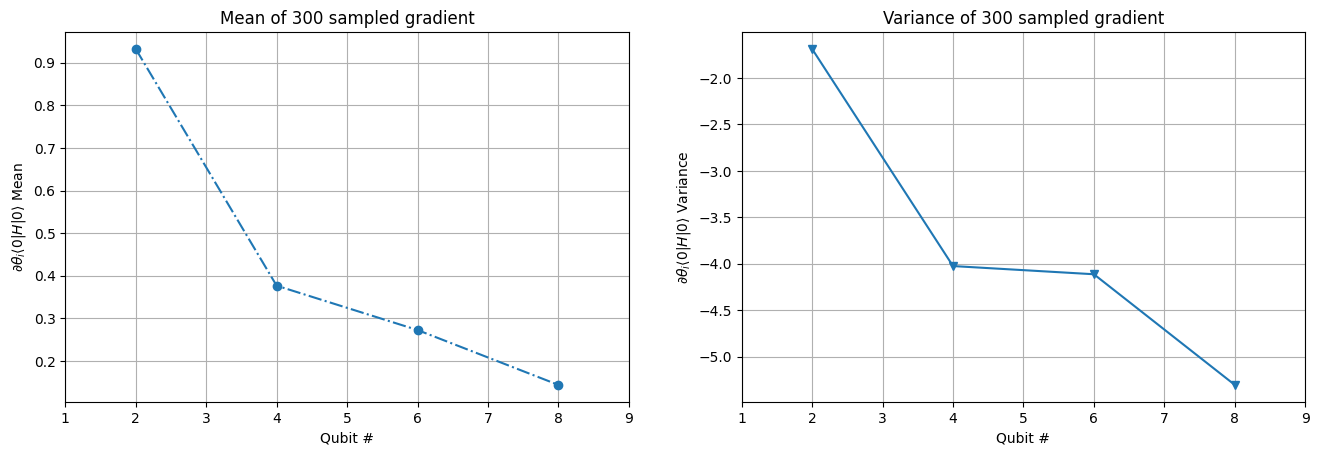

In [13]:
import matplotlib.pyplot as plt

means = np.array(means)
variances = np.array(variances)

n = np.array(selected_qubit)
print("我们接着画出这个采样出来的梯度的统计结果：")
fig = plt.figure(figsize=plt.figaspect(0.3))

# ============= 第一张图 =============
# 统计出随机采样的梯度平均值和量子比特数量的关系
plt.subplot(1, 2, 1)
plt.plot(n, means, "o-.")
plt.xlabel(r"Qubit #")
plt.ylabel(r"$ \partial \theta_{i} \langle 0|H |0\rangle$ Mean")
plt.title("Mean of {} sampled gradient".format(samples))
plt.xlim([1,9])
plt.grid()

# ============= 第二张图 =============
# 统计出随机采样的梯度的方差和量子比特数量的关系
plt.subplot(1, 2, 2)
plt.plot(n, np.log(variances), "v-")
plt.xlabel(r"Qubit #")
plt.ylabel(r"$ \partial \theta_{i} \langle 0|H |0\rangle$ Variance")
plt.title("Variance of {} sampled gradient".format(samples))
plt.xlim([1,9])
plt.grid()

plt.show()

可以看出，随着量子比特数量的增加，多次采样获得所有参数梯度的最大值不断接近于 0，且方差也是呈下降趋势。

为了进一步看看梯度随量子比特数量增加发生的变化，我们不妨可视化一下不同量子比特数量对的优化曲面的影响：

![BP-fig-qubit_landscape_compare](./figures/BP-fig-qubit_landscape_compare.png "(a)不固定 z 轴尺度时，采样出的优化曲面分别从左至右对应2、4和6量子比特的情形。（b）同样的优化曲面但是固定 z 轴尺度作为对比。")
         

画图时 $\theta_1$ 和 $\theta_2$ 是前两个电路参数, 剩余参数全部固定为 $\pi$。不然我们画不出这个高维度的流形。
结果不出所料，陡峭程度随着 $n$ 的增大越来越小了，**注意到 Z 轴尺度的极速减小**。相对于 2 量子比特的情况，6 量子比特的优化曲面已经非常扁平了。

在理论上，只有当我们选取的网络结构还有损失函数满足一定条件时 (2-design)[[1]](https://arxiv.org/abs/1803.11173), 才会出现这种梯度随量子比特数增加而急剧消失的现象。



### 应用 二：基于经典数据量子编码的监督学习

监督学习是量子神经网络的重要应用之一，然而贫瘠高原现象同样制约着量子变分算法在此类问题上的表现。因此，如何设计更有效的电路和损失函数来避免贫瘠高原现象的出现，是当前量子神经网络的重要研究方向之一。实际上，已有学者证明，在生成模型 (generative model) 的训练之中使用瑞丽熵 (Renyi divergence) 作为损失函数，可以有效避免贫瘠高原现象 [[3]](https://arxiv.org/abs/2106.09567)。 基于量桨的梯度分析模块，我们可以快速分析一个监督学习模型中梯度的相关信息，从而便于研究者尝试探索不同的量子电路和损失函数。

这里，我们利用量桨的[量子态编码经典数据](./tutorial/machine_learning/DataEncoding_CN.ipynb)提供的数据集为例进行介绍。

#### Paddle Quantum 实现

首先，导入需要的包

In [14]:
from paddle_quantum.dataset import Iris
from paddle_quantum.gradtool import random_sample_supervised, plot_supervised_loss_grad

#### 定义参数化量子电路

接着，构建参数化量子电路 $U(\theta)$ 

In [15]:
def U_theta(n: int, depth: int):
    # 初始化网络
    cir = Circuit(n)

    # 先搭建广义的旋转层
    cir.rz()
    cir.ry()
    cir.rz()

    # 默认深度为 depth = 1
    # 搭建纠缠层和 Ry旋转层
    for _ in range(3, depth + 3):
        cir.cnot()
        cir.ry()
        
    return cir

#### 定义目标函数

这里定义要优化的目标函数，第二个参数仍然是可变参数 ``*args``。

In [16]:
def loss_func(cir: Circuit, *args):
    #传入量子态和训练标签
    state_in = args[0]
    label = args[1]
    # 将 Numpy array 转换成 tensor
    label_pp = paddle.to_tensor(label).reshape([-1, 1])
    
    Utheta = cir.unitary_matrix()
    
    # 因为 Utheta是学习到的，我们这里用行向量运算来提速而不会影响训练效果
    state_out = state_in @ Utheta
    
    # 测量得到泡利 Z 算符的期望值 <Z>
    Ob = paddle.to_tensor(pauli_str_to_matrix([[1.0, 'z0']], qubit_num))
    E_Z = state_out @ Ob @ paddle.transpose(paddle.conj(state_out), perm=[0, 2, 1])

    # 映射 <Z> 处理成标签的估计值
    state_predict = paddle.real(E_Z)[:, 0] * 0.5 + 0.5
    loss = paddle.mean((state_predict - label_pp) ** 2)  #均方误差
    
    return loss
    

#### 定义数据集

接着导入量子编码后的 Iris 数据集。

In [17]:
time_start = time.time()

#超参数设置,这里不需要太多qubit，不然严重过拟合
test_rate = 0.2
qubit_num = 2
depth = 1
lr = 0.1
BATCH = 4
EPOCH = 4
SAMPLE = 300
# 验证数据集
iris = Iris(encoding='amplitude_encoding', num_qubits=qubit_num, test_rate=test_rate, classes=[0,1], return_state=True)

# 获取数据集的输入和标签
train_x, train_y = iris.train_x, iris.train_y  #这里的 train_x, train_y，test_x, test_y 都是 paddle.tensor
test_x, test_y = iris.test_x, iris.test_y
testing_data_num = len(test_y)
training_data_num = len(train_y)


# 为量子电路创建可训练的参数
# 创建电路
circuit = U_theta(qubit_num, depth)

print(circuit)

--Rz(0.907)----Ry(2.993)----Rz(0.103)----*----x----Ry(5.857)--
                                         |    |               
--Rz(5.250)----Ry(2.564)----Rz(4.133)----x----*----Ry(5.153)--
                                                              


/Users/v_zhanglei48/opt/anaconda3/envs/pq/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:


我们先看看在 EPOCH=4，BATCH=4 的情况下，训练过程中的损失函数值及梯度的变化情况

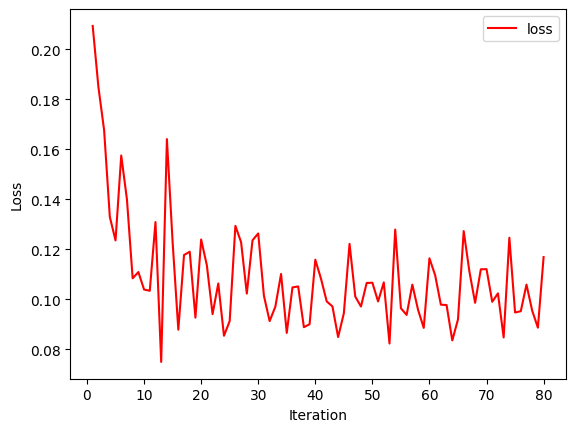

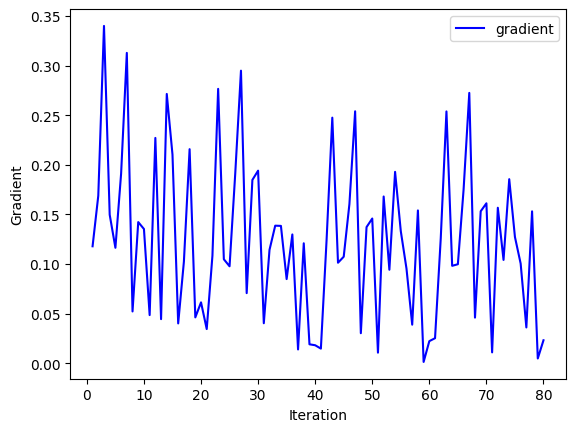

In [18]:
loss,grad = plot_supervised_loss_grad(circuit, loss_func, N=qubit_num, EPOCH=EPOCH, LR=lr,BATCH=BATCH, TRAIN_X=train_x, TRAIN_Y=train_y)

我们可以看到在几十个 iteration 之后，损失函数的值只在一个较小的范围内波动，说明训练过程已经达到了稳定。

接着我们再对该模型的初始参数进行随机采样 300 次，这里我们首先选择 ``max`` 模式，看看 300 次采样中每次采样中最大梯度的平均值和方差

Sampling: 100%|##################################################| 300/300 [00:02<00:00, 112.23it/s]


Mean of max gradient
0.14334632
Variance of max gradient
0.0034603078


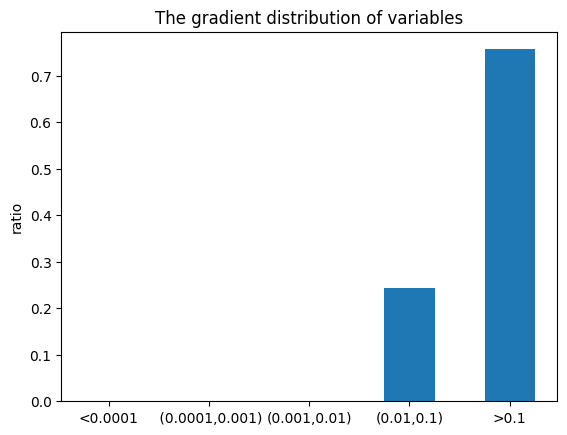

In [19]:
mean, variance = random_sample_supervised(circuit,loss_func, N=qubit_num, sample_num=SAMPLE, BATCH=BATCH, TRAIN_X=train_x, TRAIN_Y=train_y, mode='max')

## 总结

可训练性问题是目前量子神经网络的研究的一个核心方向，量桨提供的梯度分析工具支持用户对模型进行可训练性的诊断，便于贫瘠高原等问题的研究。


_______

## 参考文献

[1] McClean, J. R., Boixo, S., Smelyanskiy, V. N., Babbush, R. & Neven, H. Barren plateaus in quantum neural network training landscapes. [Nat. Commun. 9, 4812 (2018).](https://www.nature.com/articles/s41467-018-07090-4)

[2] Cerezo, M., Sone, A., Volkoff, T., Cincio, L. & Coles, P. J. Cost-Function-Dependent Barren Plateaus in Shallow Quantum Neural Networks. [arXiv:2001.00550 (2020).](https://arxiv.org/abs/2001.00550)

[3] Kieferova, Maria, Ortiz Marrero Carlos, and Nathan Wiebe. "Quantum Generative Training Using R\'enyi Divergences." arXiv preprint [arXiv:2106.09567 (2021).](https://arxiv.org/abs/2106.09567)